# Site Occupation Embedding Theory
---------------------------------------------------------

A basic implementation of Site Occupation Embedding Theory following the three papers:
    1. Mol. Phys. 115 (2017) 48
    2. PRB 97 (2018) 235105
    3. TCA 137:169 (2018)

## I. Preliminaries

The Hubbard model in 1D is the toy model to play with SOET and test the implementation. The Hubbard model is written as :

$
\hat{H} = -t \sum^{N-1}_{i=1} \sum_{\sigma} \left( \hat{c}^{\dagger}_{i,\sigma}\hat{c}_{i+1,\sigma} + h.c. \right) + U \sum^N_{i=1} \left( \hat{n}_{\uparrow,i}\hat{n}_{\downarrow,i}\right) + \sum^N_{i=1}\nu_i \hat{n}_i
$

The operators $\sum_{\sigma}\hat{c}^{\dagger}$ and $\sum_{\sigma}\hat{c}_{\sigma}$ are 4x4 matrices given by:
$$
\sum_{\sigma}\hat{c}^{\dagger}_{\sigma} = \begin{array}{|c|c|c|c|}
\hline
0&0&0&0\\ \hline
1&0&0&0\\ \hline
1&0&0&0\\ \hline
0&1&1&0\\ \hline
 \hline
\end{array}
$$
and $\sum_{\sigma}\hat{c}_{\sigma}$ is given by:
$$
\sum_{\sigma}\hat{c}_{\sigma} = \begin{array}{|c|c|c|c|}
\hline
0&1&1&0\\ \hline
0&0&0&1\\ \hline
0&0&0&1\\ \hline
0&0&0&0\\ \hline
 \hline
\end{array}
$$

The occupation number operator $\hat{n}$ is diagonal and written in matrix form as:
$$
\sum_{\sigma}\hat{n}_{\sigma} = \begin{array}{|c|c|c|c|}
\hline
0&0&0&0\\ \hline
0&1&0&0\\ \hline
0&0&1&0\\ \hline
0&0&0&2\\ \hline
 \hline
\end{array}
$$

Using these definitions and the ratio $U/t$ and $\nu/t$ with the unit of $t$ taken as 1, one can setup the Hubbard Hamiltonian and solve for the ground states.

### 1. Hubbard dimer

Consider the minimal model with two orbitals and two electrons.

In [2]:
# define standard operators
using SparseArrays
using LinearAlgebra
using Arpack
using Plots
using Arpack

Cre = SparseArrays.sparse(1.0*LinearAlgebra.Diagonal(zeros(4)));
Cre[2,1]=1.0;
Cre[3,1]=1.0;
Cre[4,2]=Cre[4,3]=1.0;
Des = SparseArrays.sparse(transpose(Cre));
Num = SparseArrays.sparse(1.0*LinearAlgebra.Diagonal(ones(4)));
Num[1,1]=0.0;
Num[2,2]=1.0;
Num[3,3]=1.0;
Num[4,4]=2.0;
Numup = SparseArrays.sparse(1.0*LinearAlgebra.Diagonal(ones(4)));
Numup[1,1]=0.0;
Numup[2,2]=1.0;
Numup[3,3]=0.0;
Numup[4,4]=1.0;
Numdn = SparseArrays.sparse(1.0*LinearAlgebra.Diagonal(ones(4)));
Numup[1,1]=0.0;
Numup[2,2]=0.0;
Numdn[3,3]=1.0;
Numdn[4,4]=1.0;
Eye = SparseArrays.sparse(1.0*LinearAlgebra.Diagonal(ones(4)));

Matrix(Cre)

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273


4×4 Array{Float64,2}:
 0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0

In [427]:
# build the Hamiltonian

# on site 1
Cre1 = kron(Cre,Eye);
Des1 = kron(Des,Eye);
Num1 = kron(Num,Eye);
Numup1 = kron(Numup,Eye);
Numdn1 = kron(Numdn,Eye);
Eye1 = kron(Eye,Eye);

# on site 2
Cre2 = kron(Eye,Cre);
Des2 = kron(Eye,Des);
Num2 = kron(Eye,Num);
Numup2 = kron(Eye,Numup);
Numdn2 = kron(Eye,Numdn);
Eye2 = Eye1;

# make the Hamiltonian
t=1.0;
U=4.0t;
U1=4.0t;
U2=4.0t;
ν=0.1t;
ν1=0.1t;
ν2=0.1t;
ϵ=10^-10;

Ham = -t*(Cre1*Des2 + Des1*Cre2) + U1*(Numup1*Numdn1) + U2*(Numup2*Numdn2) + ν1*(Num1) + ν2*(Num2);

# extract the relavant n̂ zone
nel=2.0;
Idxs = getRelavantIdxs(Num1 + Num2, nel);
HamTrunc = projectHamiltonian(Ham,Idxs);
dim = size(HamTrunc);

λ,ϕ = Arpack.eigs(HamTrunc, nev = 1, which=:SR)
λ=real(λ);
ϕ=real(ϕ);
ϕ[map.(abs,ϕ) .< ϵ].=0.0;

print("Energy=",λ,"\n")

Matrix(HamTrunc)

Energy=[-1.2641016151377544]


6×6 Array{Float64,2}:
  4.2  -1.0  -1.0  -1.0  -1.0   0.0
 -1.0   0.2   0.0   0.0   0.0  -1.0
 -1.0   0.0   0.2   0.0   0.0  -1.0
 -1.0   0.0   0.0   0.2   0.0  -1.0
 -1.0   0.0   0.0   0.0   0.2  -1.0
  0.0  -1.0  -1.0  -1.0  -1.0   4.2

# II. Analytic results

As we see above, the Hubbard Hamiltonian is quite simple for the $<\hat{n}>=2$ subspace. There are essentially three types of basis functions one with [2 0] occuaption another with [0 2] (with indices 1 and 6 respectively) and the four basis functions in the middle represent the Ms=1,0(S=1),0(S=0),-1 basis functions respectively. 

The above matrix can also be written analytically as:
$$
\hat{H}_{<\hat{n}>=2} = \begin{array}{|c|c|c|c|c|c|}
\hline
U_0+2\nu_0&-t&-t&-t&-t&0\\ \hline
-t&\nu_0+\nu_1&0&0&0&-t\\ \hline
-t&0&\nu_0+\nu_1&0&0&-t\\ \hline
-t&0&0&\nu_0+\nu_1&0&-t\\ \hline
-t&0&0&0&\nu_0+\nu_1&-t\\ \hline
0&-t&-t&-t&-t&U_1+2\nu_1\\ \hline
 \hline
\end{array}
$$

This Hamiltonian can be simplified by projecting the basis onto the S=0 spin subspace and upon taking $\frac{a\bar{b}-\bar{a}b}{\sqrt{2}}$ as one S=0 eigenfunction we get the same result as that of the paper (Eq.26):

$$
\hat{H}_{<\hat{n}>=2,S=0} = \begin{array}{|c|c|c|}
\hline
U_0+2\nu_0&-\sqrt{2}t&0\\ \hline
-\sqrt{2}t&\nu_0 + \nu_1&-\sqrt{2}t\\ \hline
0&-\sqrt{2}t&U_1+2\nu_1\\ \hline
 \hline
\end{array}
$$

## 1. Energy Functional

Here we will analyze the energy funtional and its relation to $U/t$ and $\nu/t$.

Analytic results can be found in the case of two site Hubbard model. First, we shall rewrite the above Hamiltonian in a simplified form under the assumption $\nu_1 + \nu_2 = 0$ as follows:

$$
\hat{H}_{<\hat{n}>=2,S=0} = \begin{array}{|c|c|c|}
\hline
U_0+\delta\nu&-\sqrt{2}t&0\\ \hline
-\sqrt{2}t&0&-\sqrt{2}t\\ \hline
0&-\sqrt{2}t&U_1-\delta\nu\\ \hline
 \hline
\end{array}
$$

And we obtain the same matrix as in Eq(26). Analytic diagonalization can be carried out with the assumption that $U_0 = U_1 = U$. 

One root is then written as follows:

$
\frac{\sqrt[3]{\sqrt{4 \left(18 t^2 U+U^3-9 U v^2\right)^2-4 \left(12 t^2+U^2+3 v^2\right)^3}-36 t^2 U-2 U^3+18 U v^2}}{3 \sqrt[3]{2}}+\frac{\sqrt[3]{2} \left(12 t^2+U^2+3 v^2\right)}{3 \sqrt[3]{\sqrt{4 \left(18 t^2 U+U^3-9 U v^2\right)^2-4 \left(12 t^2+U^2+3 v^2\right)^3}-36 t^2 U-2 U^3+18 U v^2}}+\frac{2 U}{3}
$

with the substitution of variable $u = U/2t$, $v=\nu/2t$ and $w=\sqrt{3\left(1 + \nu^2 \right) + u^2}$, we obtain the expression given in the Eqs 27 of paper I.

$
E(U,\delta\nu) = \frac{4t}{3}\left( u - w \sin\left( \theta + \frac{\pi}{6}\right)\right)
$

Using this result, the energy functional of the general Hamiltonian shown above can be found by using the following two relations:

$
U = \frac{U_0 + U_1}{2}
$

and

$
\delta\nu_{eff} = \delta\nu + \frac{U_1 - U_0}{2}
$

Then we get the final energy functional in terms of the general interaction parameters:

$
\mathcal{E}(U_0,U_1,\delta\nu) = E((U_0+U_1)/2,\delta\nu + (U_1 - U_0)/2))
$

## 2. Levy-Lieb Functional and $E_c$

The Levy-Lieb Functional is the equivalent of the Hohenberg-Kohn function in SOET and is a function of $t$ and $U$. The general definition of LL Functional gives the energy as a function of site occupation ($n$) and is as follows:

$
F(U,\textbf{n}) = \sup_{v}\left\{ E(v) - <v|n> \right\}
$

The Kohn-Sham formulation of SOFT gives the following partitioning of the exchange and correlation:

$
F(U,\textbf{n}) = \mathcal{T}_s(\textbf{n}) + E_{Hxc}(U,\textbf{n})
$

where $E_{Hxc}(U,\textbf{n}) = E_{Hx}(U,\textbf{n}) + E_c(U,\textbf{n})$.

From here one can obtain the correlation energy after using the definition of the Hartree exchange energy as:

$
E_{Hx} = \frac{U}{4}\sum_i \left( n^2_i \right)
$

The total correlation energy $E_c$ is:

$
E_c(U,\textbf{n}) = F(U,\textbf{n})-\mathcal{T}_s(\textbf{n})-E_{Hx}(U,\textbf{n})
E_c(U,\textbf{n}) = F(U,\textbf{n})-\mathcal{T}_s(\textbf{n})-\frac{U}{4}\left( n^2_0 + n^2_1\right)
$

The kinetic energy of the non-interacting system is given by:

$
\mathcal{T}_s(n) = -2t\sqrt(n(2-n))
$

## 3. Impurity correlation energy ($E^{imp}_c$)

The energy functional for the impurity and the system have the following relationship:

$
\mathcal{E}^{imp}(U,\delta\nu) = \mathcal{E}(U,0,\delta\nu) = E(U/2,\delta\nu - U/2)
$

where we've basically substituted used $U_1=0$ for the impurity energy.

Using the LL functional for the impurity gives the impurity correlation energy as follows:

$
F^{imp}(U,\textbf{n}) = \sup_{v}\left\{ \mathcal{E}^{imp}(v) - <v|n> \right\}
$

using the relation between the energies above this becomes:

$
F^{imp}(U,\textbf{n}) = F(U/2\textbf{n}) + \frac{U}{2}(n-1)
$


Now we can define the correlation energy of the impurity using the LL function for the impurity as follows

$
E^{imp}_c(U,n) = F^{imp}(U,n) - \mathcal{T}_s(n) - E^{imp}_{Hx}(U,n)
$

with $E^{imp}_{Hx}(U,n) = \frac{U}{4}n^2$

Therefore $E^{imp}_c$ can be obtained by $E_c$ by scaling by $\frac{1}{2}$ the U parameter:

$
E_c(U,n) = E^{imp}_c(U/2,n)
$

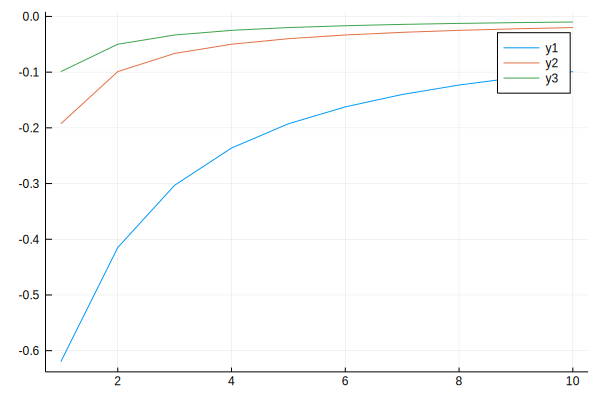

In [4]:
# Plot of the "exact" correlation energy  $E_c$

"""
Calculate the energy of a two site
Hubbard model with t, U and ν.
"""
function hubbardDimerEnergy(U,ν,t)
    u=U/(2t)
    v=ν/(2t)
    w=sqrt(3.0 * (1 + v^2) + u^2)
    θ = (1/3)*acos((9(v^2 - 0.5)-u^2)*(u/w^3))
    return((4t/3)*(u-w*sin(θ + π/6)))
end
res=zeros(10,3)
count=1
for u in 1:10
    res[count,1]=hubbardDimerEnergy(u,0.1,0.5)
    res[count,2]=hubbardDimerEnergy(5u,0.1,0.5)
    res[count,3]=hubbardDimerEnergy(10u,0.1,0.5)
    count+=1
end
plot(1:10,res)

## 4. Plots

### a.) $F(U,\nu,n)$ vs $\delta\nu$

$F(U,\nu,n) = \sup_{\nu}\left\{ E(U,\nu) + \delta\nu \times (n-1)\right\}$

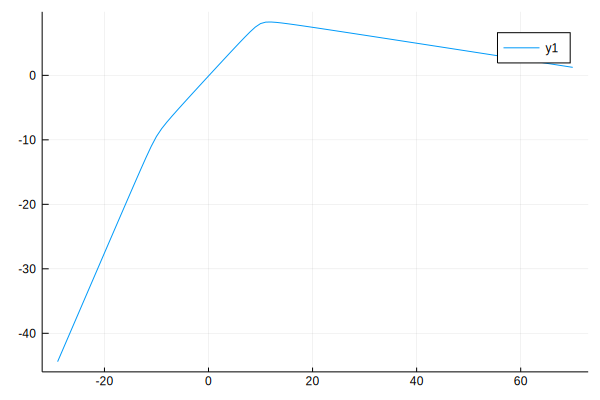

In [84]:
using Optim

"""
Maximize the Levy-Lieb Functional F(U,n)
"""
function FUn(U,ν,n)
    FUn = hubbardDimerEnergy(U,ν,0.5) + ν*(n-1)
    return FUn
end
dim=100
res=zeros(dim)
x=zeros(dim)
count=1
for u in 1:dim
    ν=(u-30)*1
    x[count]=ν
    res[count]=FUn(10.,ν,15/8)
    count+=1
end
plot(x,res)

Maximize $F_{LL}(U,\nu)$

In [87]:
"""
Maximize the Levy-Lieb Function FUn 
and return the ν which corresponds to the maximum value.
"""
function maximizeFUn(U,n)
    function f_univariate(ν)
        return -FUn(U,ν,n)
    end
    res=optimize(f_univariate, -U*5,U*5)
    return(Optim.minimizer(res))
end
maximizeFUn(10.,15/8)

11.6268943344521

### b.) $E_c$ vs $\textbf{n}$

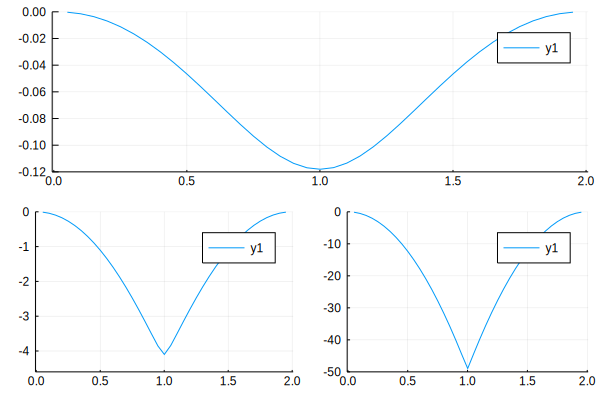

attempt to save state beyond implementation limit


In [128]:
"""
Calculate the correlation energy of 
the Hubbard model using Eq 40.
"""
function corrEnergy(U,t,n)
    Ts = -2t*sqrt(n*(2-n))
    EHx = U*(1-(n*(2-n)/2))
    ν = maximizeFUn(U,n)
    FUn = hubbardDimerEnergy(U,ν,t) + ν*(n-1)
    return(FUn-Ts-EHx)
end
res=zeros(4*11-1,3)
xaxis=zeros(4*11-1)
count=1
for n in 0.001:0.05:1.999
    res[count,1]=corrEnergy(1.0,0.5,n)
    res[count,2]=corrEnergy(10.0,0.5,n)
    res[count,3]=corrEnergy(100.0,0.5,n)
    xaxis[count]=n
    count+=1
end
p1=plot(xaxis[2:40],res[2:40,1],ylims=(-0.12,0))
p2=plot(xaxis[2:40],res[2:40,2],ylims=(-4.6,0))
p3=plot(xaxis[2:40],res[2:40,3],ylims=(-50.0,0))
l = @layout [a; b c]
plot(p1,p2,p3,layout=l)

### c.) $E_c$ and $E^{imp}_c$ vs $\textbf{n}$

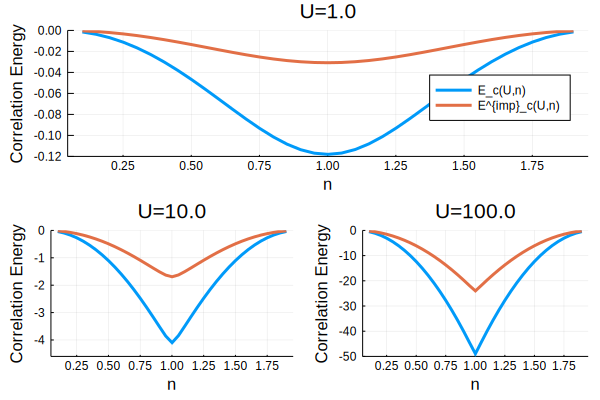

In [159]:
"""
Calculate the correlation energy of
the impurity.
"""
function corrEnergyImp(U,t,n)
    Ts = -2t*sqrt(n*(2-n))
    EHxImp = (U/4)*n*n
    ν = maximizeFUn(U/2,n)
    FUnImp = ( hubbardDimerEnergy(U/2,ν,t)  + ν*(n-1) ) + (U/2)*(n-1)
    return(FUnImp-Ts-EHxImp)
end
res=zeros(4*11-1,6)
xaxis=zeros(4*11-1)
count=1
for n in 0.001:0.05:1.999
    res[count,1]=corrEnergy(1.0,0.5,n)
    res[count,3]=corrEnergy(10.0,0.5,n)
    res[count,5]=corrEnergy(100.0,0.5,n)
    res[count,2]=corrEnergyImp(1.0,0.5,n)
    res[count,4]=corrEnergyImp(10.0,0.5,n)
    res[count,6]=corrEnergyImp(100.0,0.5,n)
    xaxis[count]=n
    count+=1
end
p1=plot(xaxis[3:39],res[3:39,1:2],title="U=1.0",ylims=(-0.12,0),ylabel="Correlation Energy",xlabel="n",label=["E_c(U,n)" "E^{imp}_c(U,n)"],lw=3,legend=:bottomright)
p2=plot(xaxis[3:39],res[3:39,3:4],title="U=10.0",ylims=(-4.6,0),ylabel="Correlation Energy",xlabel="n",legend=false,lw=3)
p3=plot(xaxis[3:39],res[3:39,5:6],title="U=100.0",ylims=(-50.0,0),ylabel="Correlation Energy",xlabel="n",legend=false,lw=3)
l = @layout [a; b c]
plot(p1,p2,p3,layout=l)

---------------------

## Helper Functions and Testing

In [394]:
"""
Get the indices of the Hamiltonian with the relavant number of
electrons.
"""
function getRelavantIdxs(Ham,nel)
    diagham = Ham[LinearAlgebra.diagind(Ham)]
    dim = length(diagham)
    Idxs = (diagham .!= nel)
    Idxs=range(1,length=dim)[Idxs]
    return(Idxs)
end

"""
Remove a row and column from 
an input matrix
"""
function deleteRowCol(A,row,col)
    B = A[1:end .!= row,:]
    C = B[:, 1:end .!= col]
    return(C)
end

"""
Project out the relavant part
of the Hamiltonian
"""
function projectHamiltonian(Ham,Idxs)
    dim = length(Idxs)
    A=Ham
    for i in 0:dim-1
        A=deleteRowCol(A,Idxs[i+1]-i,Idxs[i+1]-i)
    end
    return(A)
end

projectHamiltonian

In [386]:
tmpHam = rand(4,4)
tmpHam[1,1]=1.0;
tmpHam[2,2]=2.0;
tmpHam[3,3]=1.0;
tmpHam[4,4]=2.0;
Idxs=getRelavantIdxs(tmpHam,1.0)

2-element Array{Int64,1}:
 2
 4

In [387]:
tmpHam

4×4 Array{Float64,2}:
 1.0       0.395134   0.897717   0.338218
 0.631182  2.0        0.0370307  0.984498
 0.535447  0.0386168  1.0        0.898027
 0.706438  0.0436871  0.755633   2.0     

In [388]:
a=projectHamiltonian(tmpHam,Idxs)

2

2×2 Array{Float64,2}:
 1.0       0.897717
 0.535447  1.0     

In [389]:
a

2×2 Array{Float64,2}:
 1.0       0.897717
 0.535447  1.0     